In [1]:
# from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import os, sys, gc, pywt
import pandas as pd
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
from scipy.signal import butter, sosfilt, sosfreqz, lfilter, find_peaks, argrelextrema
import json, math
# import plotly.graph_objects as go
# from plotly.subplots import make_subplots
import pandas as pd
from io import StringIO
import array
from scipy.signal import butter, filtfilt
from scipy.interpolate import interp1d
# from fastdtw import fastdtw
# from scipy.spatial.distance import euclidean
# import neurokit2 as nk

# container_name = "testresults"

In [2]:
#Filter Banks

def butter_lowpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyquist = 0.5 * fs
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [15]:
def get_raw_pulse_features_new(beats,ccoef,window_id, SID, save_figure = True, fs=400,):
    count = 0 
    raw_pulse_features = {
        'systole': [],
        'diastole': [],
        'dicrotic': [],
        'baseline': [],
        'onset': [],
        'on_dic_time':[],
        'beat_time':[],
        'systole_time': [],
        'diastole_time': [],
        'auc_dic':[],
        'auc_systole': [],
        'auc_diastole': [],
        'auc_sys_dia': [],
        'auc': [],
        'num_beats': None
    }
    for beat in beats:
        
        if ccoef[count] > 0.9:
            ccycle = butter_lowpass_filter(beat, 5, fs)
            d1d = (np.gradient(ccycle,400))
            d1d/=np.max(d1d)
            d2d = (np.gradient(d1d,400))
            d2d/=np.max(d2d)
            d3d = (np.gradient(d2d,400))
            d3d/=np.max(d3d)
            
            ccycle_max_peak, _ = signal.find_peaks(ccycle)
            systole = ccycle_max_peak[np.argmax(ccycle[ccycle_max_peak])]
            onset = np.argmin(ccycle[:systole])
            x = systole
            y, _ = signal.find_peaks(-d1d)
            index = np.argmax(y > x)
            y=y[index]

            z, _ = signal.find_peaks(d1d)
            index = np.argmax(z > y)
            z=z[index]

            b, _ = signal.find_peaks(-d2d)
            b = b[np.argmax(-d2d[b])]

            c, _ = signal.find_peaks(d2d)
            index = np.argmax(c > b)
            c=c[index]

            f = 0 # some error for SMS009


            if d2d[c]>=0:
                e = c
                diff = np.diff(d2d[b:e])
                sign_changes = np.sign(diff[:-1]) != np.sign(diff[1:])
                if any(sign_changes):
                    #Handle This For Case II
                    print('Case II')
                    c, _ = signal.find_peaks(-d3d)
                    index = np.argmax(c > b)
                    c=c[index]

                    d, _ = signal.find_peaks(-d3d)
                    index = np.argmax(d > c)
                    d=d[index]

                    for idx in range(c,len(d3d)):
                        if d3d[idx] == 0 or d3d[idx] < 0:
                            e = idx
                            break

                    f_tmp = None
                    for idx in range(e+1,len(d3d)):
                        if (f_tmp == None) and (d3d[idx] == 0 or d3d[idx] < 0):
                            f_tmp = idx

                        if f_tmp!= None:
                            if d3d[idx] == 0 or d3d[idx] > 0:
                                f = idx
                                break

                else:
                    #Handle This For Case I
                    # print('Case I')
                    c, _ = signal.find_peaks(d3d)
                    index = np.argmax(c > b)
                    c=c[index]
        
                    for idx in range(c,len(d2d)):
                        if d2d[idx] == 0 or d2d[idx] > 0:
                            d = idx
                            break
        
                    for idx in range(c,len(d3d)):
                        if d3d[idx] == 0 or d3d[idx] < 0:
                            e = idx
                            break
                    
                    f_tmp = None
                    for idx in range(e+1,len(d3d)):
                        if (f_tmp == None) and (d3d[idx] == 0 or d3d[idx] < 0):
                            f_tmp = idx

                        if f_tmp!= None:
                            if d3d[idx] == 0 or d3d[idx] > 0:
                                f = idx
                                break

            else:
                #Handle For Case III
                # print('Case III')

                c, _ = signal.find_peaks(d2d)
                index = np.argmax(c > b)
                c=c[index]

                d, _ = signal.find_peaks(-d2d)
                index = np.argmax(d > c)
                d=d[index]

                e, _ = signal.find_peaks(d2d)
                index = np.argmax(e > c)
                e=e[index]

                f, _ = signal.find_peaks(-d2d)
                index = np.argmax(f > e)
                f=f[index]

                    
            # cut_off = int(0.8*len(ccycle))
            # dia_pk, _ = signal.find_peaks(ccycle)
            # index = np.argmax((dia_pk > f) & (dia_pk < cut_off))
            # f = dia_pk[index]

            cut_off = int(0.8*len(ccycle))
            baseline = 0
            for idx in range(cut_off,len(d2d)):
                if ccycle[idx] == ccycle[onset] or ccycle[idx] < ccycle[onset]:
                    baseline = idx
                    break

            if onset < systole < e < f < baseline:    
                if save_figure:   
                    plt.figure()
                    plt.plot(ccycle)
                    plt.plot(onset,ccycle[onset],'yo',label='onset')
                    plt.plot(systole,ccycle[systole],'bo',label='sys')
                    plt.plot(e,ccycle[e],'go',label='dic')
                    plt.plot(f,ccycle[f],'ko',label='dia')
                    plt.plot(baseline,ccycle[baseline],'co',label='base')
                    plt.axhline([0])
                    plt.axhline(ccycle[onset])

                    plt.plot(d1d,label='dy_dx')
                    # plt.plot(x,d1d[x],'bo')
                    plt.plot(y,d1d[y],'yo')
                    plt.plot(z,d1d[z],'bo')
                    # plt.plot(d2d,'k')
                    # plt.plot(b,d2d[b],'co',label='b')
                    # plt.plot(c,d2d[c],'r*',label='c')
                    # plt.plot(d,d2d[d],'b*',label='d')
                    # plt.plot(e,d2d[e],'b*',label='e')
                    # plt.plot(f,d2d[f],'c*',label='f')
                    # plt.plot(d3d,'y')
                    plt.legend()
                    # plt.savefig(f'features_extended/raw/new_{SID}_{window_id}_{count}.png')
                    # plt.close()
                    
                systole_time = (systole - onset) / fs
                diastole_time = (baseline - systole) / fs
                on_dic_time = (e - onset)/fs

                auc = np.trapz(ccycle[onset:baseline])
                auc_systole = np.trapz(ccycle[onset:systole])
                auc_dic = np.trapz(ccycle[onset:e])
                auc_diastole = np.trapz(ccycle[systole:baseline])

                
                raw_pulse_features['systole'].append(ccycle[systole]-ccycle[onset])
                raw_pulse_features['diastole'].append(ccycle[f]-ccycle[onset])
                raw_pulse_features['dicrotic'].append(ccycle[e]-ccycle[onset])
                raw_pulse_features['baseline'].append(ccycle[baseline])
                raw_pulse_features['onset'].append(ccycle[onset])
                raw_pulse_features['on_dic_time'].append(on_dic_time)
                raw_pulse_features['systole_time'].append(systole_time)
                raw_pulse_features['diastole_time'].append(diastole_time)
                raw_pulse_features['auc_dic'].append(auc_dic)
                raw_pulse_features['auc_systole'].append(auc_systole)
                raw_pulse_features['auc_diastole'].append(auc_diastole)
                raw_pulse_features['auc'].append(auc)
                raw_pulse_features['beat_time'].append(systole_time+diastole_time)
                raw_pulse_features['auc_sys_dia'].append(auc_systole/auc_diastole)

        else:
                pass
                #Some error handling

        count += 1

    raw_pulse_features['num_beats'] = len(beats)
    return raw_pulse_features

def get_raw_pulse_features_old(beats,ccoef,window_id, SID, save_figure = False,  fs=400,):

    raw_pulse_features = {
        'systole': [],
        'diastole': [],
        'dicrotic': [],
        'baseline': [],
        'onset': [],
        'beat_time':[],
        'systole_time': [],
        'diastole_time': [],
        'auc_systole': [],
        'auc_diastole': [],
        'auc_sys_dia': [],
        'auc': [],
        'num_beats': None
    }


    count = 0 

    for beat in beats:
        
        if ccoef[count] > 0.9:
            diastole_flag = False
            dicrotic_flag = False
            diastole_idx = None
            wave_ignore = False
            
            ccycle = butter_lowpass_filter(beat, 5, fs)
            ccycle_max_peak, _ = signal.find_peaks(ccycle)
            
            # if the signal has two well defined peaks then they are likely a systole and diastole
            if ccycle_max_peak.size == 2:
                systole = ccycle_max_peak[np.argmax(ccycle[ccycle_max_peak])]
                
                # if (ccycle_max_peak[1] > ccycle_max_peak[0]) and ((ccycle_max_peak[1]-systole) > 100): #0.4ms difference 
                #     diastole = ccycle_max_peak[1] #systole + np.argmax(ccycle[systole+1:int(0.8*len(ccycle))])
                #     print(f'D1 - {SID}_{count}_{window_id}')
                #     diastole_flag = True

                # if this is the case, generally the dicrotic notch is also present
                try:
                    dicrotic_peaks,_ = signal.find_peaks(-1*ccycle[systole:int(0.8*len(ccycle))])
                    
                    peak_values = ccycle[dicrotic_peaks]
                    dicrotic = systole + dicrotic_peaks[np.argmin(peak_values)]
                    # dicrotic = dicrotic_peaks[1]
                    if dicrotic != None:                    
                        dicrotic_flag = True

                except:
                    dicrotic_flag = False

            else:        
                systole = ccycle_max_peak[np.argmax(ccycle[ccycle_max_peak])]


            # Onset is the first point before systole where the gradient is minimum
            onset = np.argmin(ccycle[:systole])

            # Baseline is the lowest point after systole
            baseline = systole + np.argmin(ccycle[systole:])

            dy_dx = np.gradient(ccycle, 1/fs) 
            d2y_dx2 = np.gradient(dy_dx, 1/fs) 

 
            if not diastole_flag:
                diastole_min_peak,_ = signal.find_peaks(-1*d2y_dx2)
                
                if diastole_min_peak[-1] > 0.8*len(ccycle):
                    diastole = diastole_min_peak[-2]
                    diastole_idx = -2
                else:
                    diastole = diastole_min_peak[-1]
                    diastole_idx = -1
            
            if not dicrotic_flag or (dicrotic > diastole):            
                dicrotic_peak,_ = signal.find_peaks(d2y_dx2)
                if dicrotic_peak.size > 2:
                    if (dicrotic_peak[2] > dicrotic_peak[1]) and (dicrotic_peak[2] < diastole):
                        dicrotic = dicrotic_peak[2]

                        if d2y_dx2[dicrotic_peak[2]] < d2y_dx2[dicrotic_peak[1]]:
                            dicrotic = dicrotic_peak[1]
                    else:
                        if d2y_dx2[dicrotic_peak[2]] > d2y_dx2[dicrotic_peak[1]]:
                            dicrotic = dicrotic_peak[2]
                        else:
                            dicrotic = dicrotic_peak[1]
                else:
                    dicrotic = dicrotic_peak[1]

            dn_dp_len = diastole - dicrotic
            if dn_dp_len < 0 :
                if dicrotic < int(0.8*len(ccycle)):
                    try:
                        diastole = dicrotic + np.argmin(d2y_dx2[dicrotic:int(0.8*len(ccycle))])
                    except:
                        print(f'wave not ideal for computation - {SID}_{count}_{window_id}')
                        wave_ignore = True
                else:
                    try:
                        dicrotic = systole + np.argmax(d2y_dx2[systole:diastole])
                    except:
                        print(f'wave not ideal for computation - {SID}_{count}_{window_id}')
                        wave_ignore = True


            # if diastole != None and dicrotic!= None:
            #     dicrotic_tmp = np.argmin(ccycle[dicrotic:diastole])

            #     if (dicrotic_tmp != None) and (dicrotic_tmp != dicrotic) and (dicrotic_tmp != diastole):
            #         dicrotic = dicrotic_tmp

            # if diastole_idx != None:
            #     if dn_dp_len > abs(dicrotic-diastole_min_peak[diastole_idx-1]): #choose the diastole closest to dicrotic
            #         print(dn_dp_len, abs(dicrotic-diastole_min_peak[diastole_idx-1]),diastole_min_peak[diastole_idx-1],dicrotic,systole )
            #         if diastole_min_peak[diastole_idx-1] > dicrotic and diastole_min_peak[diastole_idx-1] > systole : 
                        
            #             diastole = diastole_min_peak[diastole_idx-1]
                        
            #         else:
            #             pass # Case to be handled

            if onset < systole < dicrotic < diastole < baseline and wave_ignore==False:

                # Plot for verification
                if save_figure:
                    plt.figure()
                    plt.plot(ccycle, label='PPG Signal')
                    plt.plot(baseline, ccycle[baseline], 'ro', label='Baseline')
                    plt.plot(systole, ccycle[systole], 'go', label='Systole')
                    plt.plot(d2y_dx2/np.max(d2y_dx2))
                    plt.axvline(0.8*len(ccycle))
                    # plt.axvline(0.6*len(ccycle))
                    
                    try:
                        plt.plot(dicrotic, ccycle[dicrotic], 'bo', label='Dicrotic Notch')
                        plt.plot(diastole, ccycle[diastole], 'ko', label='Diastole')
                    except:
                        pass

                    plt.plot(onset, ccycle[onset], 'co', label='Onset')

                    plt.title(f'{SID}_{count}_{window_id}_{ccoef[count]}')
                    plt.legend()
                    # plt.savefig(f'features_extended/raw/old_{SID}_{count}_{window_id}.png')
                    # plt.close()
                
                
                systole_time = (systole - onset) / fs
                diastole_time = (baseline - systole) / fs

                auc = np.trapz(ccycle[onset:baseline])
                auc_systole = np.trapz(ccycle[onset:systole])
                auc_diastole = np.trapz(ccycle[systole:baseline])

                raw_pulse_features['systole'].append(ccycle[systole])
                raw_pulse_features['diastole'].append(ccycle[diastole])
                raw_pulse_features['dicrotic'].append(ccycle[dicrotic])
                raw_pulse_features['baseline'].append(ccycle[baseline])
                raw_pulse_features['onset'].append(ccycle[onset])
                raw_pulse_features['systole_time'].append(systole_time)
                raw_pulse_features['diastole_time'].append(diastole_time)
                raw_pulse_features['auc_systole'].append(auc_systole)
                raw_pulse_features['auc_diastole'].append(auc_diastole)
                raw_pulse_features['auc'].append(auc)
                raw_pulse_features['beat_time'].append(systole_time+diastole_time)
                raw_pulse_features['auc_sys_dia'].append(auc_systole/auc_diastole)

            else:
                # plt.figure()
                # plt.plot(ccycle, label='PPG Signal')
                # plt.plot(baseline, ccycle[baseline], 'ro', label='Baseline')
                # plt.plot(systole, ccycle[systole], 'go', label='Systole')
                # plt.plot(d2y_dx2/np.max(d2y_dx2))
                # plt.axvline(0.8*len(ccycle))
                # # plt.axvline(0.6*len(ccycle))
                
                # try:
                #     plt.plot(dicrotic, ccycle[dicrotic], 'bo', label='Dicrotic Notch')
                #     plt.plot(diastole, ccycle[diastole], 'ko', label='Diastole')
                # except:
                #     pass

                # plt.plot(onset, ccycle[onset], 'co', label='Onset')

                # plt.title(f'{SID}_{count}_{window_id}_{ccoef[count]}')
                # plt.legend()
                # plt.savefig(f'wave not ideal for computation - {SID}_{count}_{window_id}.png')
                
                # print(f'wave not ideal for computation - {SID}_{count}_{window_id}')
                pass

        count += 1

    raw_pulse_features['num_beats'] = len(beats)
    gc.collect()
    return raw_pulse_features

def get_c_peaks(dy_dx, fs = 400):
    return signal.find_peaks(dy_dx,distance = 0.4*fs,height=(0.35*np.max(dy_dx),np.max(dy_dx)))

# The LVET is defined in the DPPG signal as the time interval between the first zero crossing point and
# the minimum point. The LVETs of heartbeats measured by high-quality PPG pulses would become
# more accurate

def get_x_fid(dy_dx, c_peaks):
    x_fid = []
    for i in range(1,len(c_peaks)-1):
        end = int(0.65*(c_peaks[i+1] - c_peaks[i]))
        # x_fid.append(c_peaks[i] + np.argmin(dy_dx[c_peaks[i]:(c_peaks[i]+end)]))
        x_pks,_ = signal.find_peaks(np.multiply(-1,dy_dx[c_peaks[i]:(c_peaks[i]+end)]))
        x_fid.append(c_peaks[i] + x_pks[0])

    return x_fid

def b_limits_r(dy_dx, c_peaks):
    first_pass = False
    b_lim_r = []
    prev_peak = None
    for peak in c_peaks:
        if first_pass == False:
            first_pass = True
            prev_peak = peak
        else:
            
            for idx_range in range(peak,int(0.5*(peak-prev_peak)),-1):
                if dy_dx[idx_range] < 0.15*dy_dx[peak]:
                    b_lim_r.append(idx_range)
                    break
            prev_peak = peak

    return b_lim_r


def b_limits_l(dy_dx, c_peaks):
    first_pass = False
    b_lim_l = []
    prev_peak = None
    for peak in c_peaks:
        if first_pass == False:
            first_pass = True
            prev_peak = peak
        else:
            
            start = peak - int(0.5*(peak-prev_peak))
            b_lim_l.append(start + np.argmin(dy_dx[start:peak]))
            prev_peak = peak

    return b_lim_l


def get_b_peaks(dy_dx,blimL, blimR):
    b_fids = []
    if len(blimL) == len(blimR):
        for i in range(0,len(blimL)):
            for idx_range in range(blimR[i],blimL[i],-1):
                if dy_dx[idx_range] == 0 or dy_dx[idx_range] < 0:
                    b_fids.append(idx_range)
                    break
        return b_fids
    else:
        return -1




In [5]:
def is_window_usable(seg,peak_list):
    segment = []

    if len(peak_list) > 2:
        for idx in range(0,len(peak_list)- 2):
            
            portion_of_data = seg[peak_list[idx]:peak_list[idx+1]]
            m1 = peak_list[idx] + np.argmin(portion_of_data)
            portion_of_data = seg[peak_list[idx+1]:peak_list[idx+2]]
            m2 = peak_list[idx+1] + np.argmin(portion_of_data)
            segment.append(seg[m1-5:m2+5])

        max_length = max(len(beat_seg) for beat_seg in segment)
        padded_segments = [resample_signal(beat_seg, max_length) for beat_seg in segment]
        summed_wave = np.sum(padded_segments, axis=0)
        temp_wave = summed_wave / len(segment)

        temp_wave = np.asarray(temp_wave).flatten() 
        _seg = [np.asarray(seg).flatten() for seg in segment]

        ccoef = []
        for padded_seg in padded_segments:
            ccoef.append(round(np.corrcoef(padded_seg, temp_wave)[0][1],2))

        
        count_ccoef = sum(1 for coef in ccoef if coef > 0.9)
        if count_ccoef/len(ccoef) > 0.5:
            return True, padded_segments, temp_wave, ccoef, count_ccoef/len(ccoef)
        else:
            return False, padded_segments, temp_wave, ccoef, count_ccoef/len(ccoef)
    else:
        return False, None, None, None, None
    
def resample_signal(signal, target_length):
    x = np.linspace(0, len(signal) - 1, num=len(signal))
    f = interp1d(x, signal, kind='linear')
    x_new = np.linspace(0, len(signal) - 1, num=target_length)
    return f(x_new)

In [6]:
fL = 0.7
fH = 15
fs = 400


icg_data = open('ID001.json')
icg_data = json.load(icg_data)['raw_data']

[0.98, 0.97, 0.98, 0.99, 1.0, 0.99, 0.99, 0.94, 0.99, 0.99, 0.98]
[0.96, 0.97, 0.97, 0.98, 0.98, 0.98, 0.87, 0.96, 0.98, 0.98]


/var/folders/3q/2dymrhy53c75l8wxnt3h655w0000gn/T/ipykernel_91306/3436192975.py:60: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15,5))


[0.99, 0.97, 0.98, 0.92, 0.98, 0.99, 0.99, 0.97, 0.98]
[0.97, 0.98, 0.97, 0.97, 0.93, 0.95, 0.97, 0.99, 0.97, 0.94]
[0.98, 0.95, 0.93, 0.94, 0.98, 0.97, 0.98, 0.96, 0.94, 0.97]


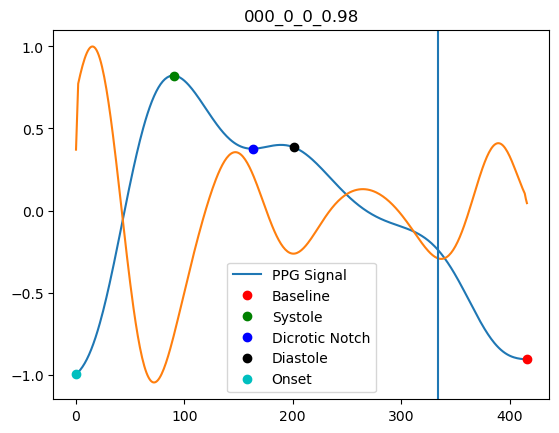

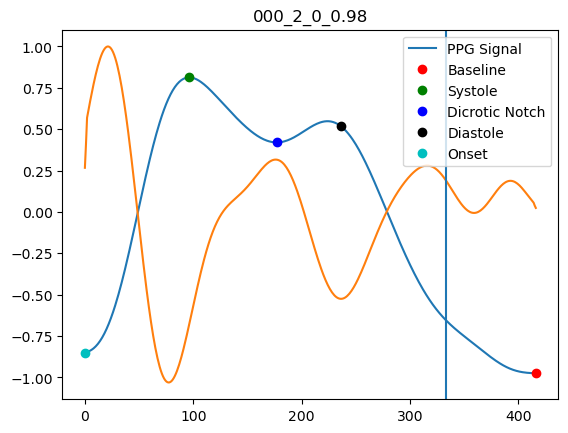

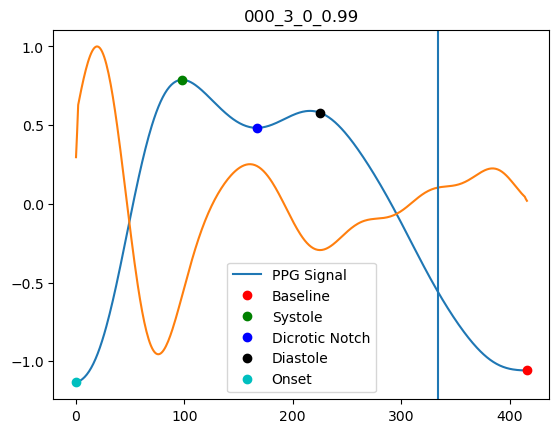

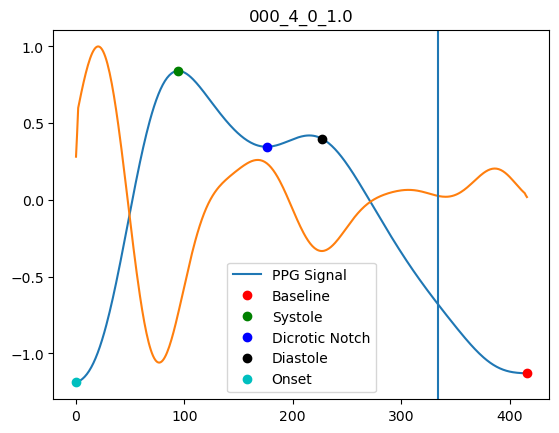

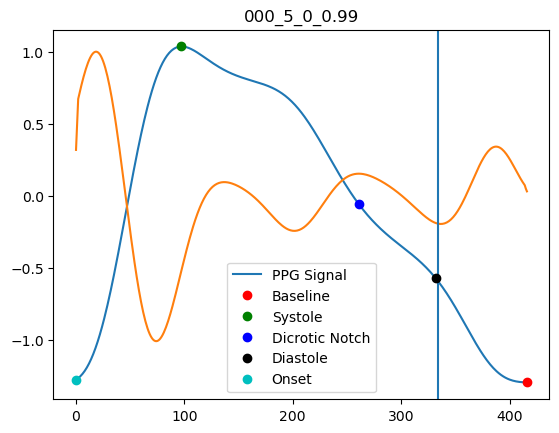

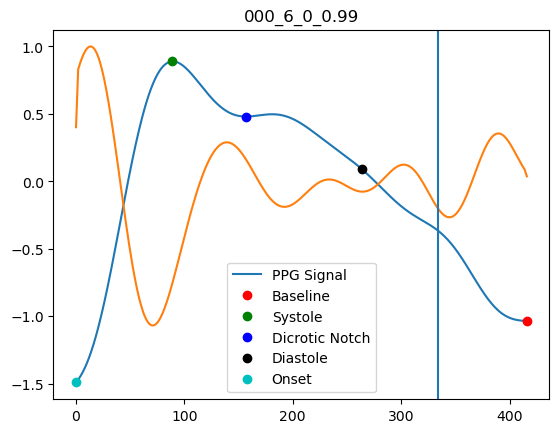

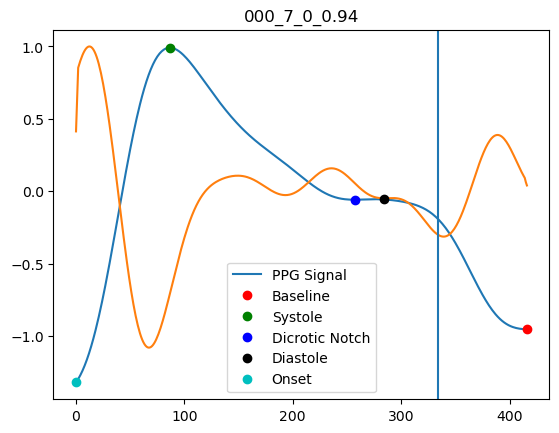

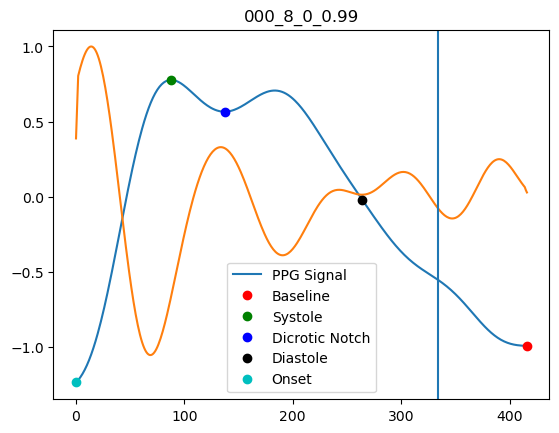

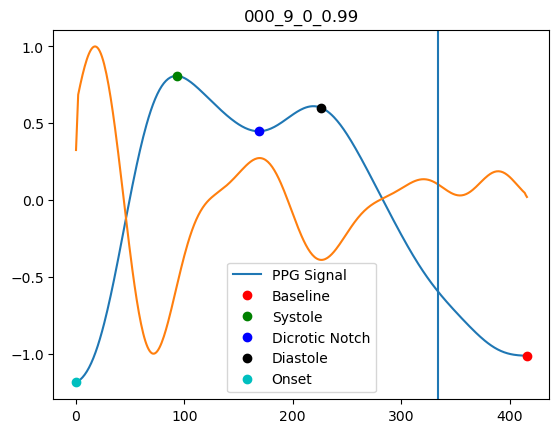

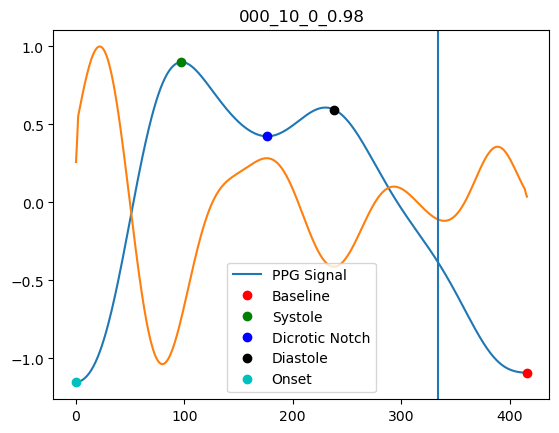

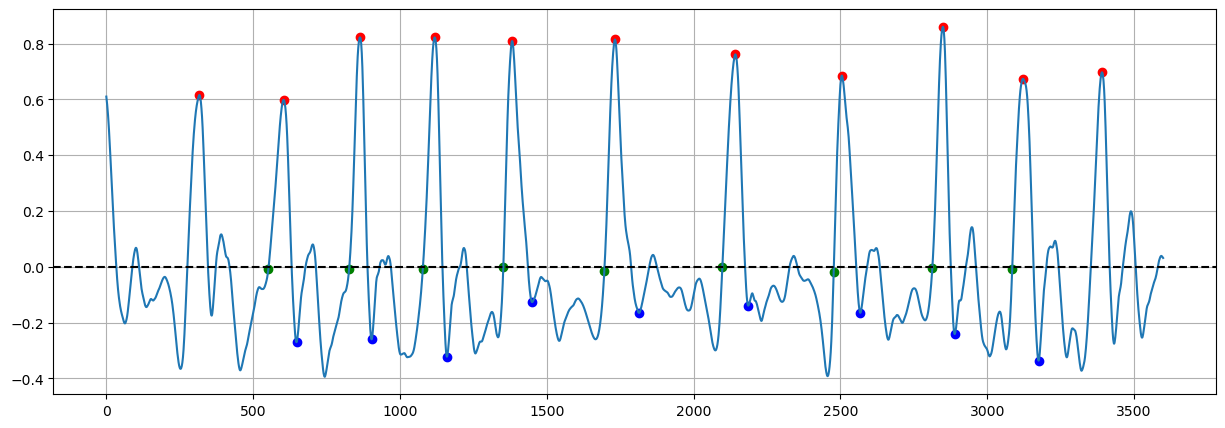

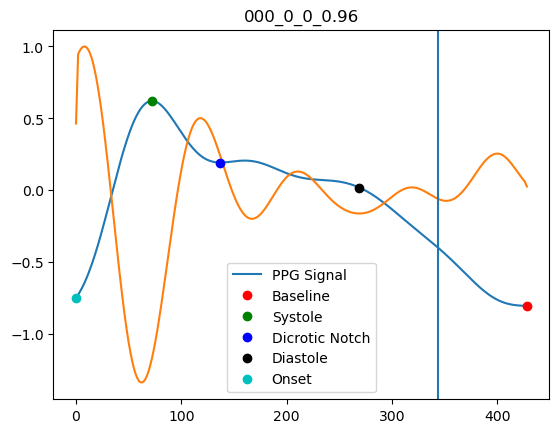

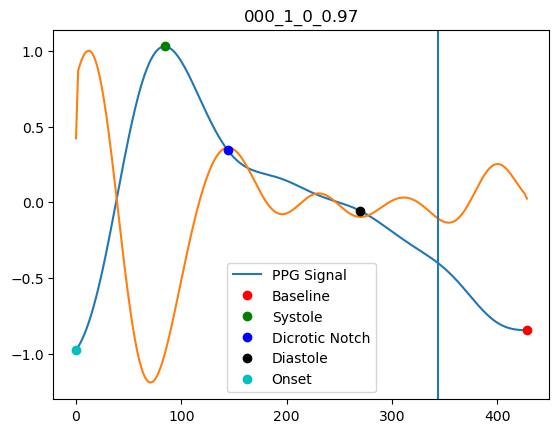

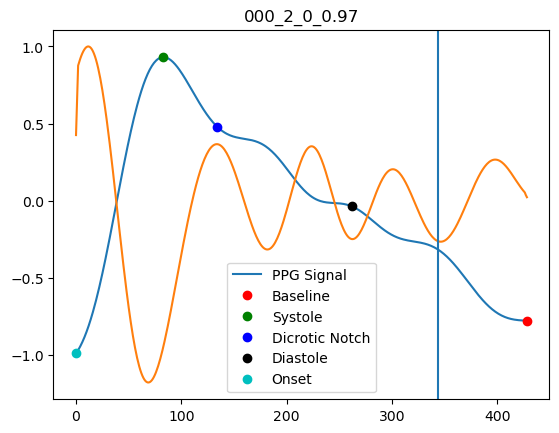

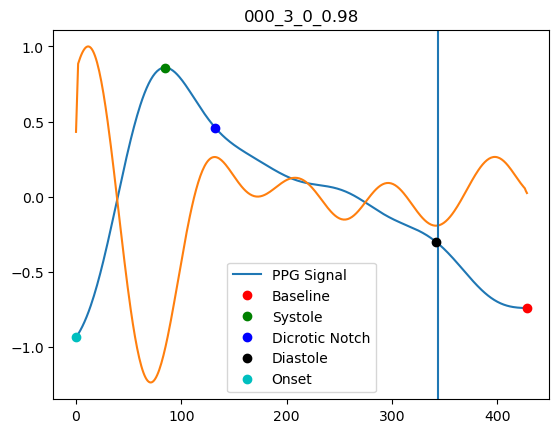

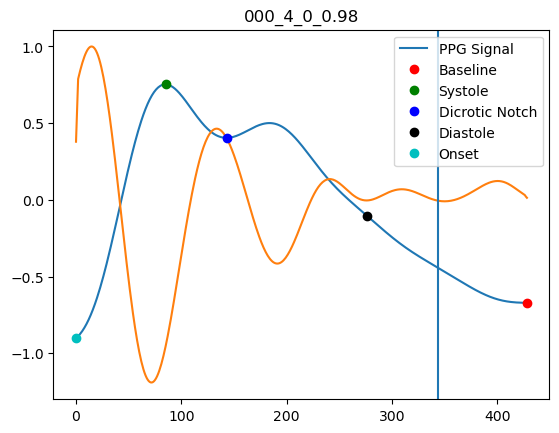

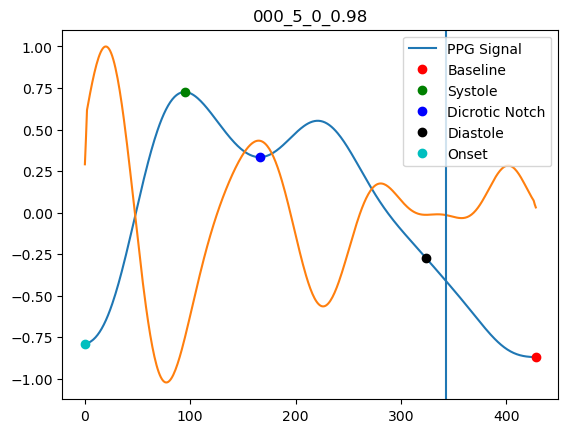

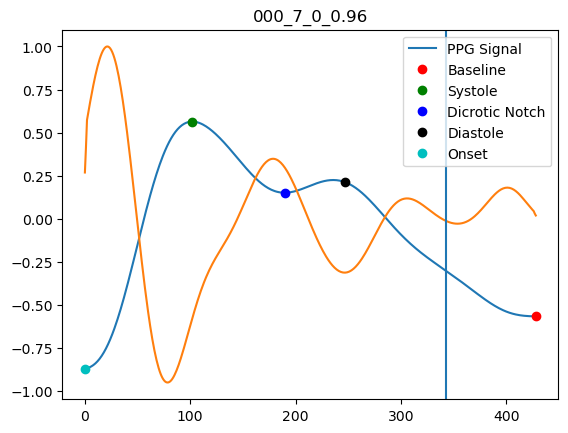

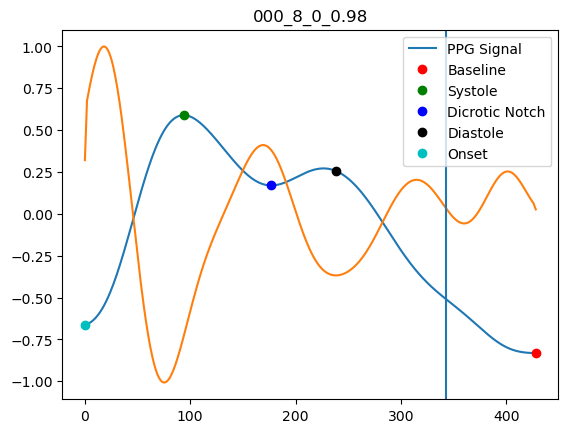

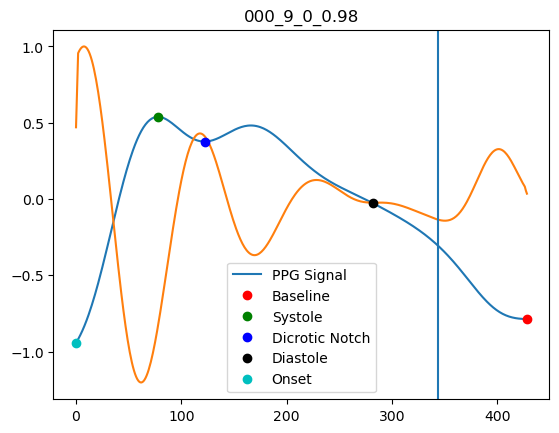

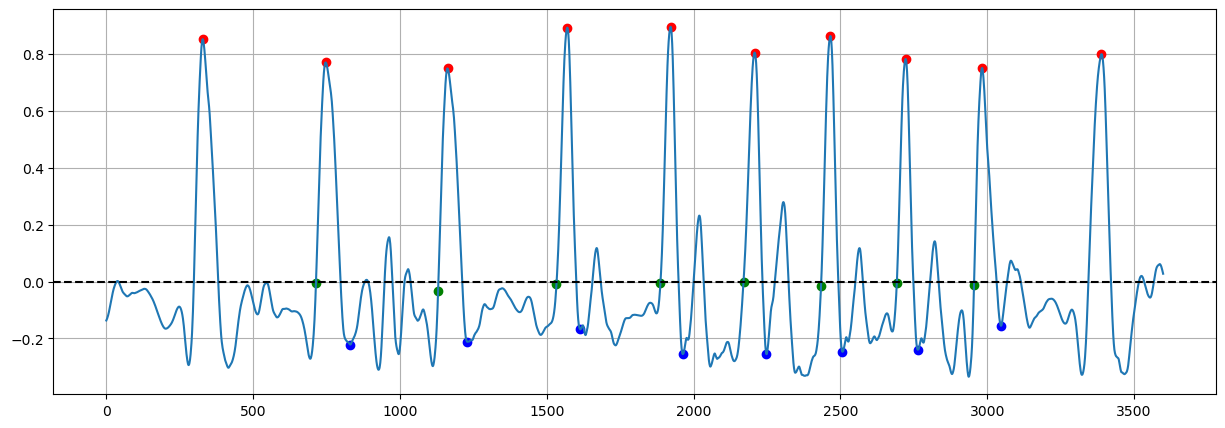

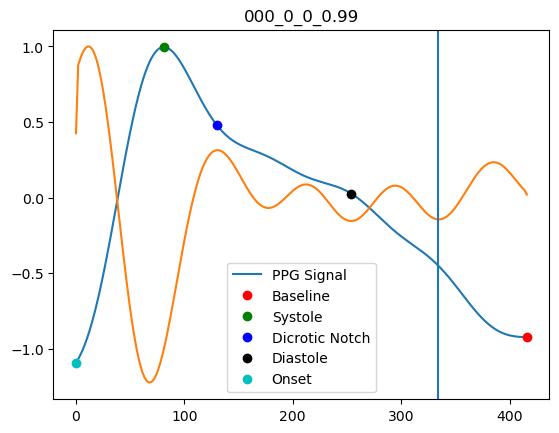

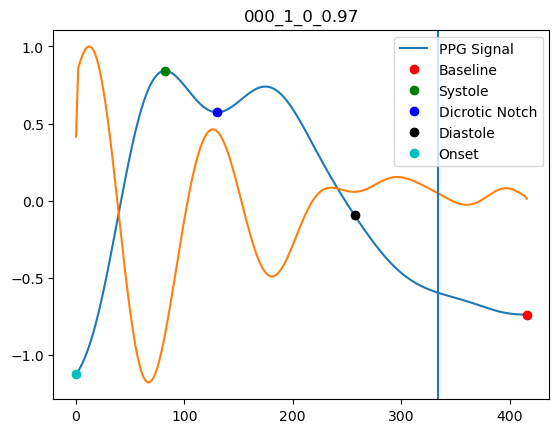

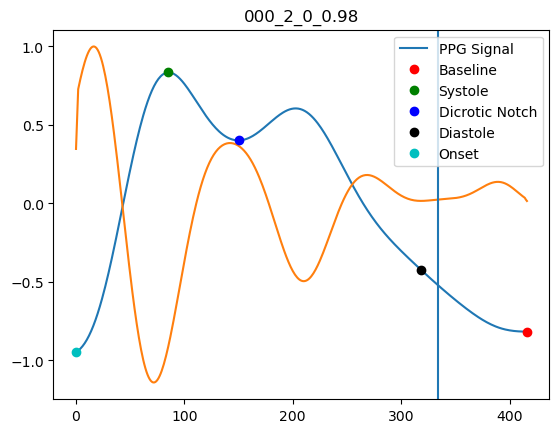

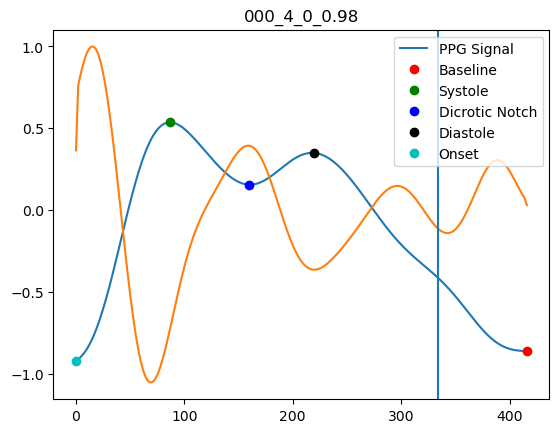

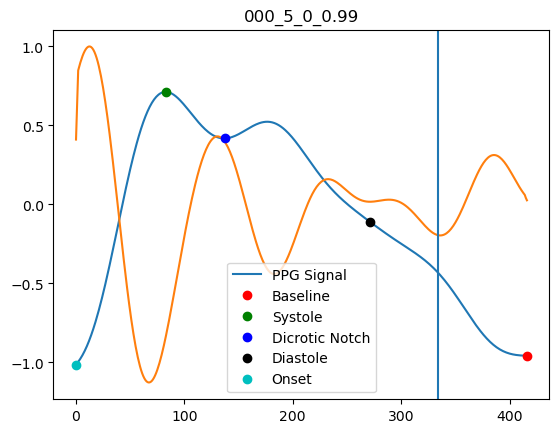

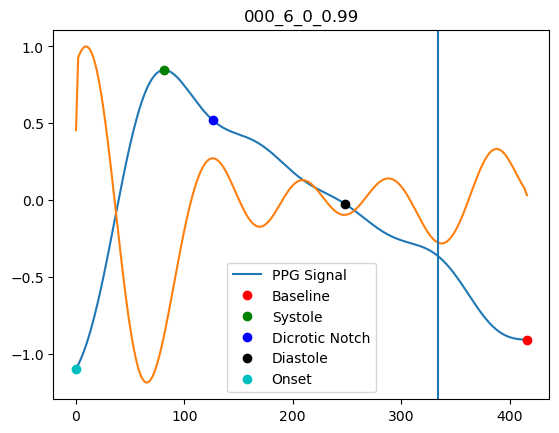

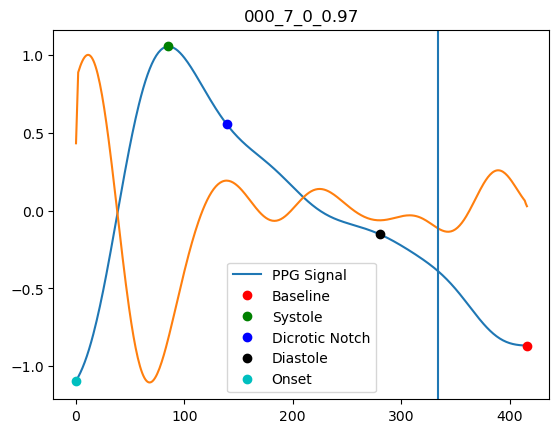

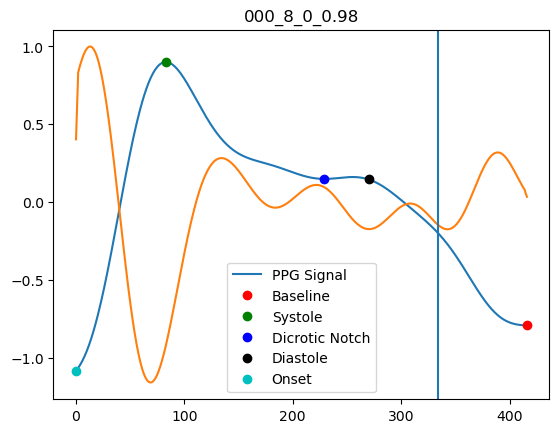

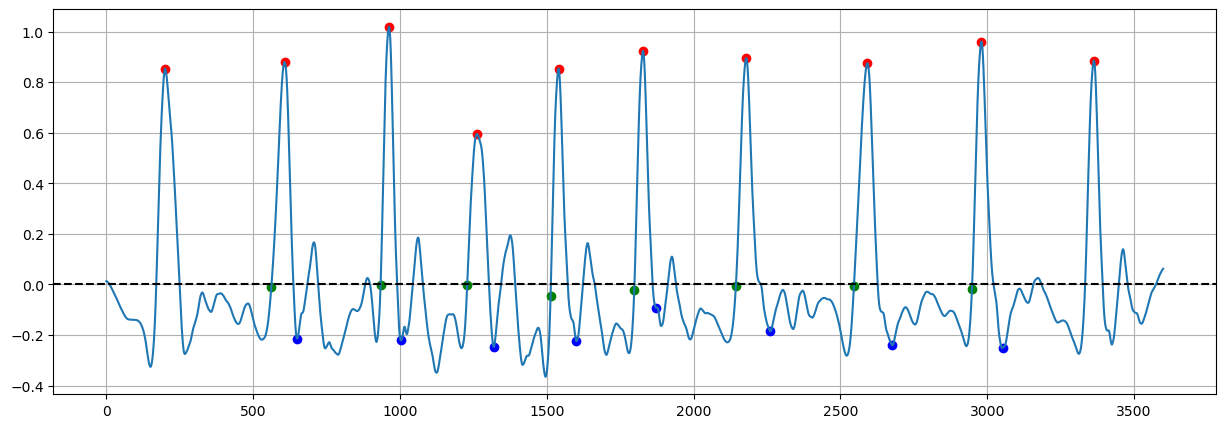

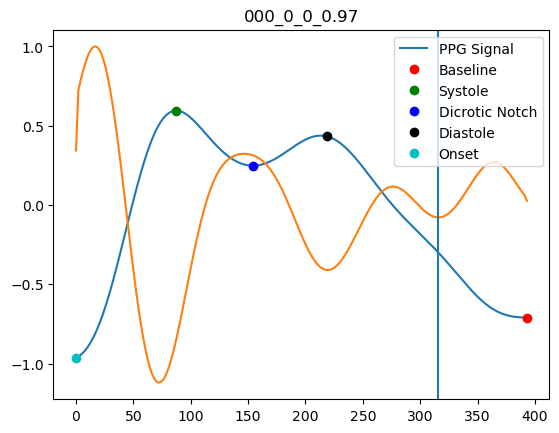

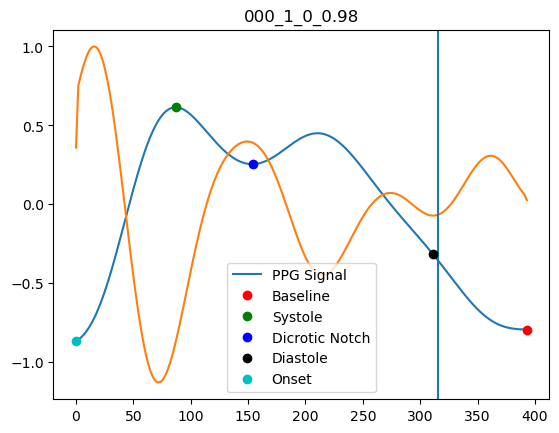

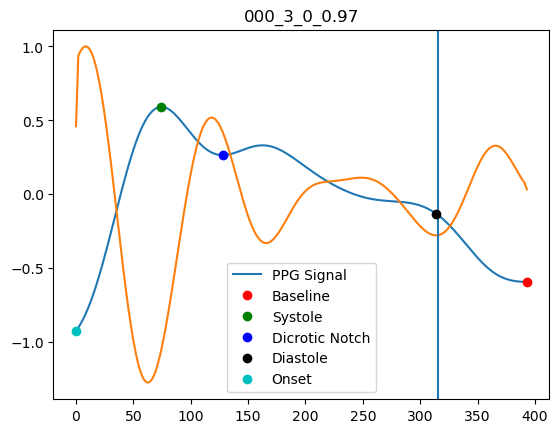

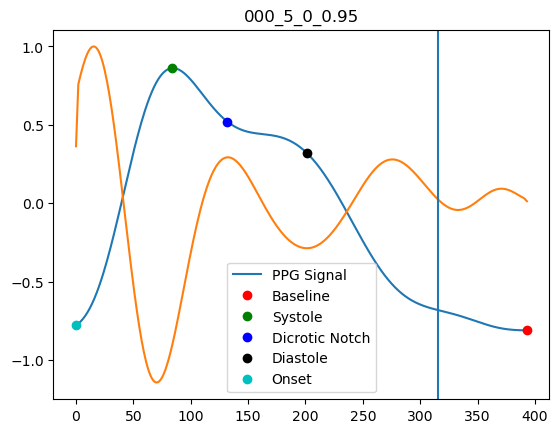

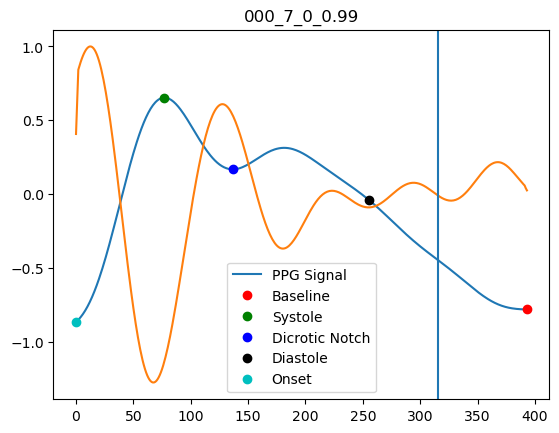

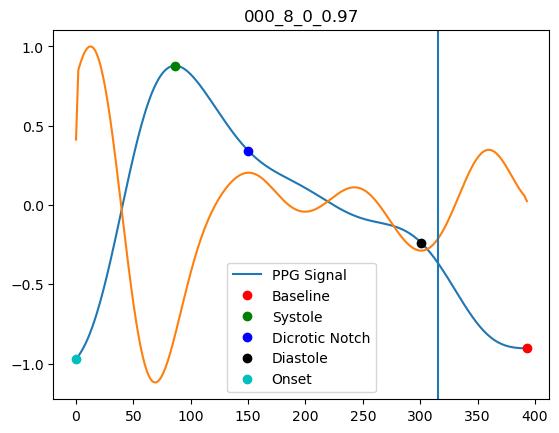

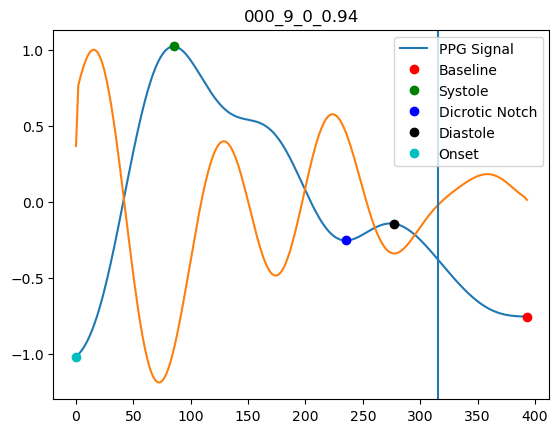

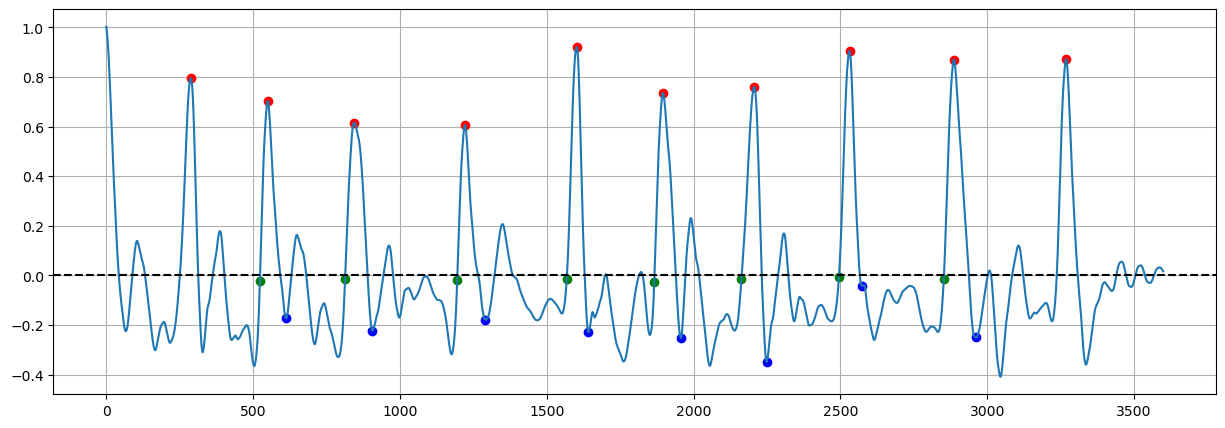

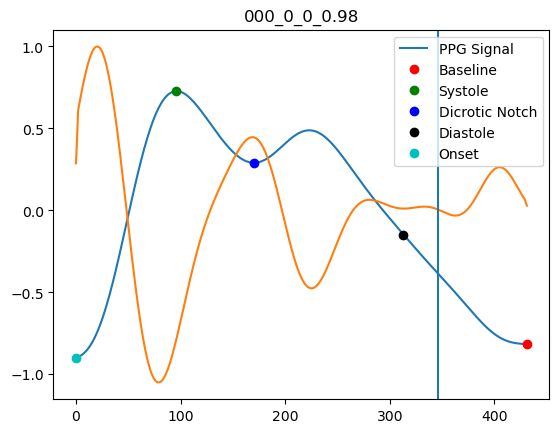

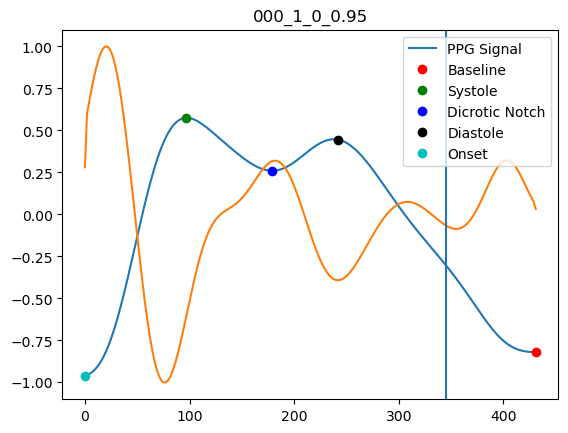

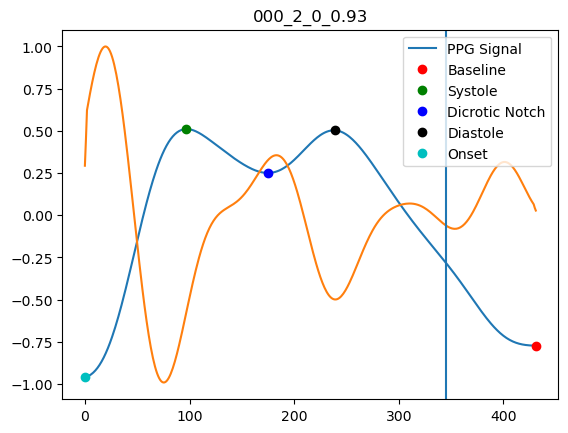

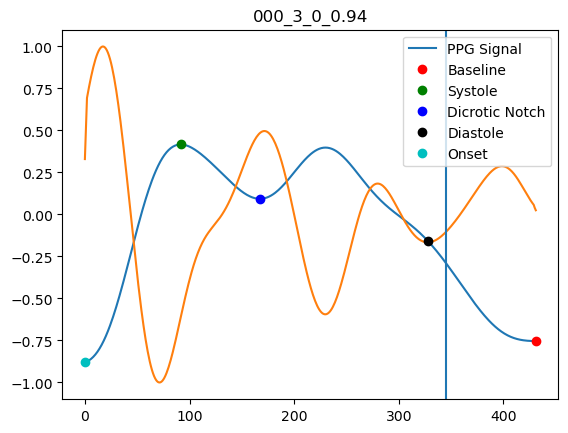

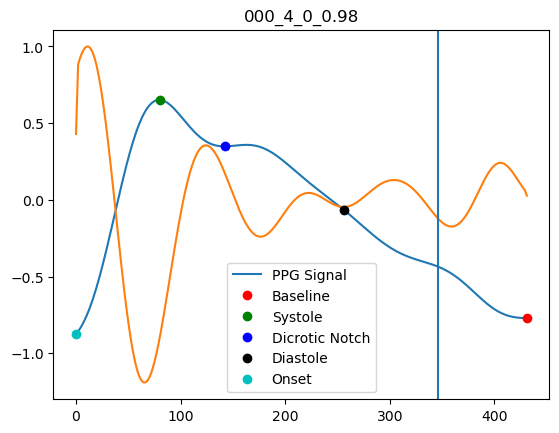

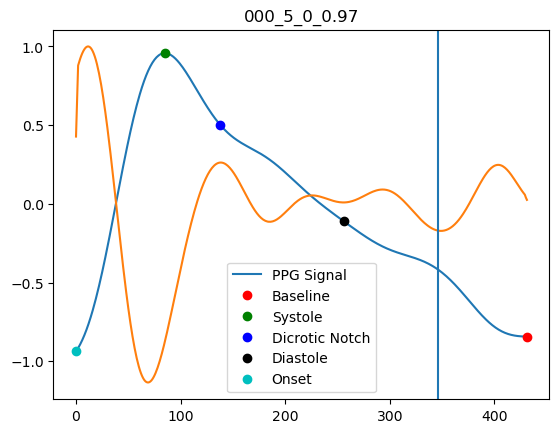

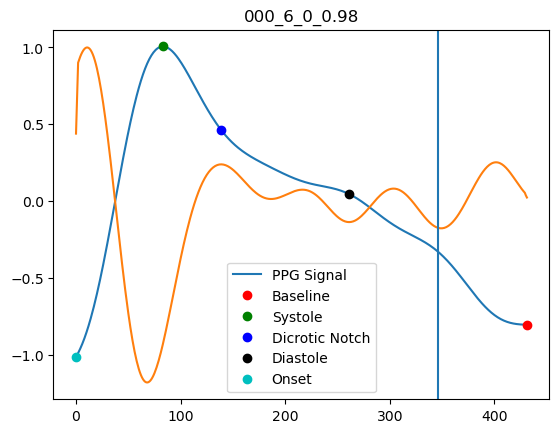

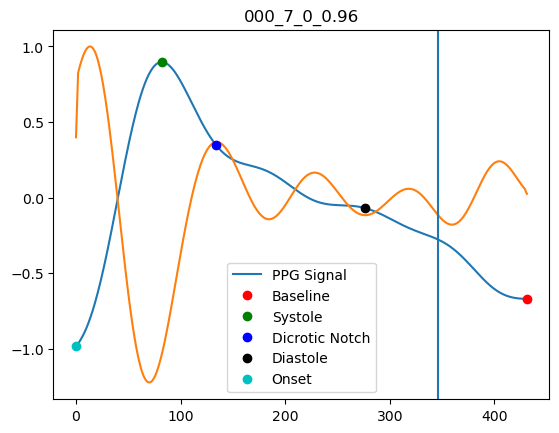

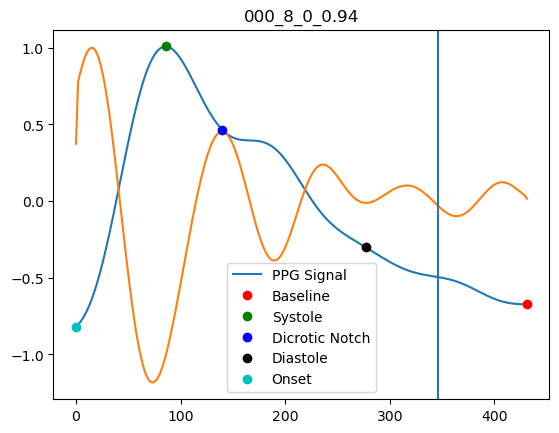

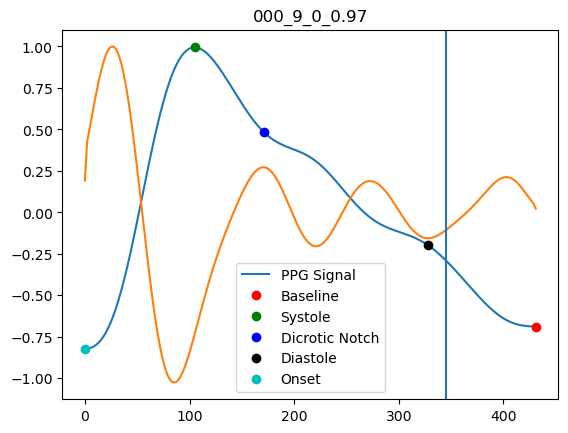

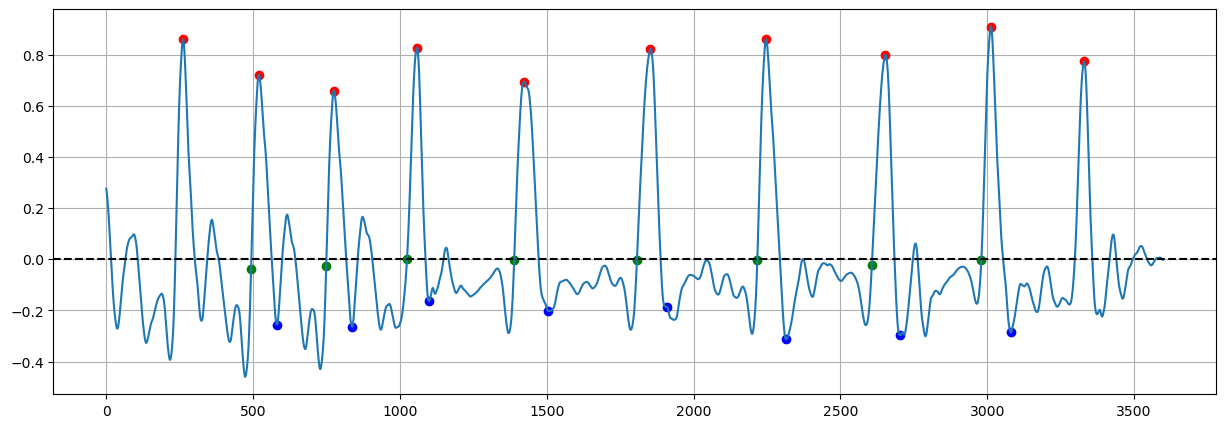

In [16]:
for step in range(0*400,60*400,10*400):
    window = icg_data[step:step+(10*400)] 
    filter_window = np.multiply(-1,butter_lowpass_filter(butter_highpass_filter(window, fL, fs), fH, fs))

    filter_window = filter_window / np.max(filter_window)

    coeffs = pywt.wavedec(filter_window, 'sym8', level=5)

    for i in range(len(coeffs)):
        if i not in [0]:  
            coeffs[i] = np.zeros_like(coeffs[i])

    approximate_dwt = pywt.waverec(coeffs, 'sym8')
    approximate_dwt /= np.max(approximate_dwt)

    _ibis, _ = signal.find_peaks(approximate_dwt, distance = 0.4*fs, height = (0.35*np.max(approximate_dwt), np.max(approximate_dwt)))

    usable, beat_segments, beat_tmp, ccoef, ccoef_score  = is_window_usable(filter_window,_ibis)
    c_pk = []
    et = []
    hr = []
    
    window_id = 0
    SID = '000'
    if usable:
        data_frame = get_raw_pulse_features_old(beat_segments,ccoef,window_id,SID, save_figure=True, fs=400)
        print(ccoef)

        filter_window = filter_window[400:]
        dy_dx = np.gradient(filter_window, fs)
        dy_dx = dy_dx / np.max(dy_dx)
        data = dy_dx

        c_pks,_ = get_c_peaks(dy_dx)
        c_pk.extend(dy_dx[c_pks])

        wavelet_type = 'db6'
        coeffs = pywt.wavedec(data, wavelet_type, level=5)

        # Zero out all levels except level in array
        for i in range(len(coeffs)):
            if i not in [0]:  
                coeffs[i] = np.zeros_like(coeffs[i])

        #Mean and std
        y = pywt.waverec(coeffs, wavelet_type)
        try:
            c_peaks,_ = get_c_peaks(y)
            b_lim_l = b_limits_l(y,c_peaks)
            b_lim_r = b_limits_r(y,c_peaks)
            b_fid = get_b_peaks(y, b_lim_l, b_lim_r)
            x_fid = get_x_fid(y, c_peaks)

            if len(x_fid) != len(b_fid):
                b_fid.pop(-1) 
            et.extend(np.multiply(1000/400,np.subtract(x_fid,b_fid)))
            num_pks = len(c_peaks)
            hr.append(num_pks*6.67)

            plt.figure(figsize=(15,5))
            plt.plot(x_fid,y[x_fid],'bo')
            plt.plot(b_fid,y[b_fid],'go')
            plt.plot(c_peaks,y[c_peaks],'ro')
            plt.plot(y)
            plt.axhline(0, color='k', linestyle='--')
            plt.grid()
        except:
            pass

    window_id+=1
    


In [17]:
data_frame


{'systole': [0.727887173637819,
  0.574861241635062,
  0.5107898991444867,
  0.4163924571489471,
  0.6521601248604739,
  0.9576776386208466,
  1.0065532290559367,
  0.8972747807368795,
  1.0085106066853005,
  0.994736155043972],
 'diastole': [-0.14720001719653192,
  0.4450502755350395,
  0.5031888578307486,
  -0.15944083986099938,
  -0.06500377461561112,
  -0.11123992798768503,
  0.04598945421671161,
  -0.06931923149383665,
  -0.302048205594712,
  -0.1983578241942325],
 'dicrotic': [0.29063876917227177,
  0.26030562328748225,
  0.25066624017882866,
  0.09299668692368496,
  0.34860732401892836,
  0.5004087542807873,
  0.4605488931308363,
  0.3461436753030042,
  0.4638663413340378,
  0.4840148322593465],
 'baseline': [-0.8153405752326605,
  -0.8209842063274286,
  -0.7727097093738483,
  -0.7546225368971848,
  -0.7713956994908836,
  -0.8436850035368045,
  -0.8047173390323015,
  -0.6711037215387727,
  -0.6742857857535351,
  -0.6884553780180852],
 'onset': [-0.8989131679293304,
  -0.95969604